# Urban Simulation Exercise 3

In [2]:
# import relevant packages and functions
from random import choice, randint, shuffle, choices
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np

In [3]:
class Building:    
    # initialize building
    def __init__(self, geometry):
        '''input: geometry (Shapley geometry object)'''
        self.geometry = geometry # store Shapely geometry object as attribute
        
        self.agents = [] # stores agents located within the cell
        self.crimes = 0 # tracks the number of crimes committed in the cell
    
    def distance(self, b):
        '''input: b (Building object)
            returns the Euclidean distance between the object and b'''
        return self.geometry.distance(b.geometry)


class Agent:
    def __init__(self, a_type, building, budget):
        '''inputs:
            a_type (str): type of agent - resident/criminal,
            building (Building object): building in which the agent starts the simulation
            budget (int): resources at the disposal of the agent
            '''
        self.a_type = a_type
        self.building = building
        self.budget = budget
        
        building.agents.append(self) # locate agent inside the cell
    
    def resident_step(self):
        '''step method for resident agents - moves to a random new building in which friend agents are located'''
        self.budget += 1 # resources increase with every step
        # find all buildings in which connected agents are present
        candidates = [a.building for a in nx.generators.ego_graph(model.network, self, radius=3) 
                      if a.building != self.building]
        if len(candidates) == 0: # if there are none, find all buildings except current
            candidates = [b for b in model.buildings if b != self.building] 
        new_building = choice(candidates) # choose new building
        return new_building
        
    def criminal_utility(self, building, max_agents):
        '''Computes the utility the agent derives from the input building, 
        based on distance and number of agents in the building.
        Inputs: building (Building object) - the building for which to compute utility, 
        max_agents (int) - the maximal number of agents present in one building (required for normalization)'''
        d = self.building.distance(building) # compute distance of current position from distance
        if d > self.budget: # if distance if greater than budget - utility is zero
            return 0
        
        d_utility = 1 - d / self.budget # normalize distance by budget and compute the inverse
        c_utility = len(building.agents) / max_agents # normalize number of agents by maximal number of agents
        # compute utility as a linear combination of distance utility and crime utility, using weight
        utility = model.weight * c_utility + (1 - model.weight) * d_utility
        return utility
    
    def criminal_step(self):
        '''step method for criminal agents - 
        move to a random building based on probabilities, randomly select an agent and steal 1 resource point'''
        buildings = [b for b in model.buildings if b != self.building] # get all buildings but current
        max_agents = max([len(b.agents) for b in buildings]) # find the maximal number of agents per building
        utilities = [self.criminal_utility(b, max_agents) for b in buildings] # compute utility value per building
        if sum(utilities) > 0: # choices require that the sum of weights would be greater than 0
            new_building = choices(buildings, utilities)[0] # randomly (with weights based on probabilities) choose one building
        else: # if utilities sum to zero
            new_building = choice(buildings) # choose a random building
            
        if new_building.agents: # if there are any agents in the building (empty list==False)
            agent = choice(new_building.agents) # randomly choose an agent present in the building
            if agent.budget > 0: # if the agent has any resources - steal one unit
                agent.budget -= 1 # remove one unit of resources from selected agent
                self.budget += 1 # add one unit to current agent
                new_building.crimes += 1 # increase the new building's crime counter
    
        return new_building
    
    def step(self):
        '''General step method for both types of agents:
            locates new building and makes the required changes'''
        if self.a_type == 'resident': # check agent type and activate step method
            new_building = self.resident_step()
        else:
            new_building = self.criminal_step()
        
        self.building.agents.remove(self) # remove current agent from current building
        new_building.agents.append(self) # add current agent to new building
        self.building = new_building # move current agent to new building
        

class Model:
    def __init__(self, residents_num, criminal_num, weight, bldgs, connections, simulation):
        '''inputs: residents_num (int) - number of resident agents,
        criminal_num (int) - number of criminal agents,
        weight (float) - weight parameter of crime factor in utility function
        bldgs (GeoDataFrame object) - geodata on buildings
        connections (int) - number of other agents an agent knows
        simulation - the simulation number'''
        
        self.weight = weight
        self.connections = connections
        self.simulation = simulation
        self.data = [] # used to store the output measures per simulation iteration
        self.map = []
        
        # create a list of building objects
        self.buildings = [Building(row.geometry) for idx, row in bldgs.iterrows()]
        # create a 1d Array of Agent objects  (length==resident_num) located in a random building and with a random budget
        self.residents = [Agent('resident', choice(self.buildings), randint(50, 800)) for i in range(residents_num)]
        # create a 1d Array of Agent objects  (length==criminal_num) located in a random building and with budget==50
        self.criminals = [Agent('criminal', choice(self.buildings), 50) for i in range(criminal_num)]
        
        # inititate social network
        self.network = nx.Graph()
        
        self.network.add_nodes_from(self.residents) # add resident agents to network
        
        for a in self.network.nodes: # for every resident agent = for every node
            candidates = [f for f in self.network.nodes if f != a] # find all agents that are not a
            distances = [a.building.distance(f.building) for f in candidates] # compute distance from agents
            sorted_distances = sorted(distances) # sort distances from lowest to highest
            ranks = [sorted_distances.index(d) for d in distances] # get a rank score for each distance
            # choose only agents whose rank is lower than connections
            friends = [candidates[i] for i in range(len(candidates)) if ranks[i] < connections]
            for f in friends:
                self.network.add_edge(a, f) # add an edge to the network between agent and friend
    
    def simulate(self):
        '''Run 30 iterations and return the total number of crimes, maximal number of crimes per building,
        and percent of buildings where no crimes were registered througout the simulation'''
        for i in range(30):
            agents = self.residents + self.criminals # merge the lists of agents into one
            shuffle(agents) # randomly reorder the merged list
            for agent in agents: # execute step function per agent
                agent.step()
        
            # generate outputs - get the count of crimes per building
            crimes = [b.crimes for b in self.buildings]
            total_crimes = sum(crimes) # total number of crimes committed throughout the simulation
            max_crimes = max(crimes) # get the counter value for the building with the most crimes committed
            # compute the percent of buildings where no crime was committed
            no_crimes = 100 * len([c for c in crimes if c==0]) / len(self.buildings)
            # store output values for the iteration
            self.data.append([self.weight, self.connections, self.simulation, i, total_crimes, max_crimes, no_crimes])
        
        # document the number of crimes per building at the end of the simulation
        for b in self.buildings:
            self.map.append([self.weight, self.connections, self.simulation, b.geometry.x, b.geometry.y, b.crimes])
            
        
results = [] # stores simulation outputs
maps = [] # store final maps
criminal_num = 40
buildings = gpd.read_file('/Users/noamgal/Downloads/bldgs_points(2)/bldgs_points.shp')
for weight in [0.25, 0.5, 0.75]:
    for connections in [1, 2, 3]:
        for simulation in range(5):
            print(weight, connections, simulation)
            model = Model(200-criminal_num, criminal_num, weight, buildings, connections, simulation)
            model.simulate()
            for l in model.data:
                results.append(l)
            for l in model.map:
                maps.append(l)

0.25 1 0
0.25 1 1
0.25 1 2
0.25 1 3
0.25 1 4
0.25 2 0
0.25 2 1
0.25 2 2
0.25 2 3
0.25 2 4
0.25 3 0
0.25 3 1
0.25 3 2
0.25 3 3
0.25 3 4
0.5 1 0
0.5 1 1
0.5 1 2
0.5 1 3
0.5 1 4
0.5 2 0
0.5 2 1
0.5 2 2
0.5 2 3
0.5 2 4
0.5 3 0
0.5 3 1
0.5 3 2
0.5 3 3
0.5 3 4
0.75 1 0
0.75 1 1
0.75 1 2
0.75 1 3
0.75 1 4
0.75 2 0
0.75 2 1
0.75 2 2
0.75 2 3
0.75 2 4
0.75 3 0
0.75 3 1
0.75 3 2
0.75 3 3
0.75 3 4


# Part A – Time Series Figures

In [5]:
# df for the results
df = pd.DataFrame(results, columns=['weight', 'connection','simulation #','iteration #','total crimes',
'maximal crimes per cell', '% of crime-free cells'])
                                    

In [6]:
print(df)

      weight  connection  simulation #  iteration #  total crimes  \
0       0.25           1             0            0            13   
1       0.25           1             0            1            19   
2       0.25           1             0            2            30   
3       0.25           1             0            3            31   
4       0.25           1             0            4            41   
...      ...         ...           ...          ...           ...   
1345    0.75           3             4           25           110   
1346    0.75           3             4           26           115   
1347    0.75           3             4           27           118   
1348    0.75           3             4           28           123   
1349    0.75           3             4           29           128   

      maximal crimes per cell  % of crime-free cells  
0                           2              98.568019  
1                           3              98.210024  
2     

/Users/noamgal/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/noamgal/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/noamgal/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/noamgal/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

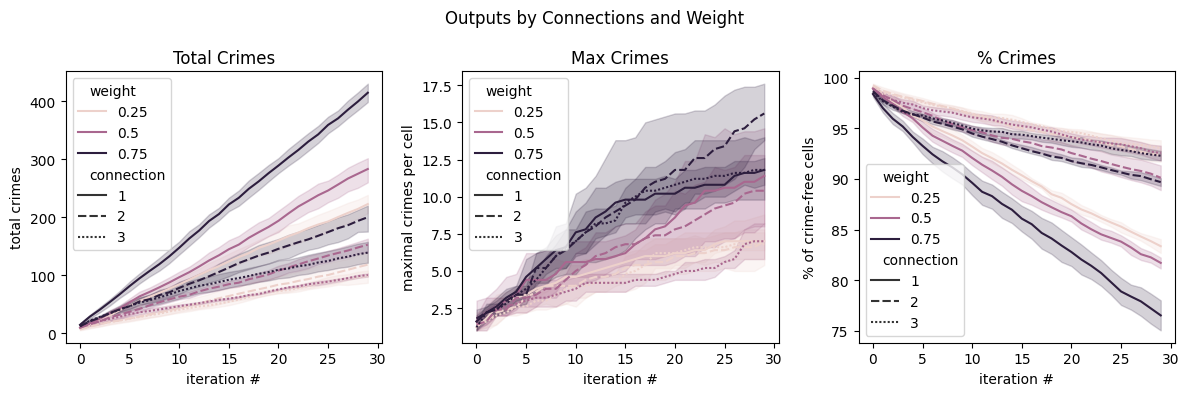

In [7]:
# Create a Figure object with three axes and define the figure size
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Total Crimes Plot 
sns.lineplot(data=df, x='iteration #', y='total crimes', hue='weight', style='connection', ax=ax1)
ax1.set_title('Total Crimes')

# Max Crimes Plot
sns.lineplot(data=df, x='iteration #', y='maximal crimes per cell', hue='weight', style='connection', ax=ax2)
ax2.set_title('Max Crimes')

# % Crimes Plot 
sns.lineplot(data=df, x='iteration #', y='% of crime-free cells', hue='weight', style='connection', ax=ax3)
ax3.set_title('% Crimes')

# Adjust layout, add suptitle, and display
fig.suptitle('Outputs by Connections and Weight')
plt.tight_layout()
plt.show()
fig.savefig('/Users/noamgal/Downloads/new-fig')

# Part B - Map

In [9]:
df_map = pd.DataFrame(maps, columns = ['weight', 'connections', 'simulation', 'geometryx', 'geometryy', 'crimes'])

In [10]:
print(df_map.head())

   weight  connections  simulation      geometryx      geometryy  crimes
0    0.25            1           0  179440.517599  665590.686665       0
1    0.25            1           0  179065.524136  666038.260678       0
2    0.25            1           0  178775.372698  665999.322819       0
3    0.25            1           0  178752.190574  666039.235536       0
4    0.25            1           0  179140.403053  665668.530084       0


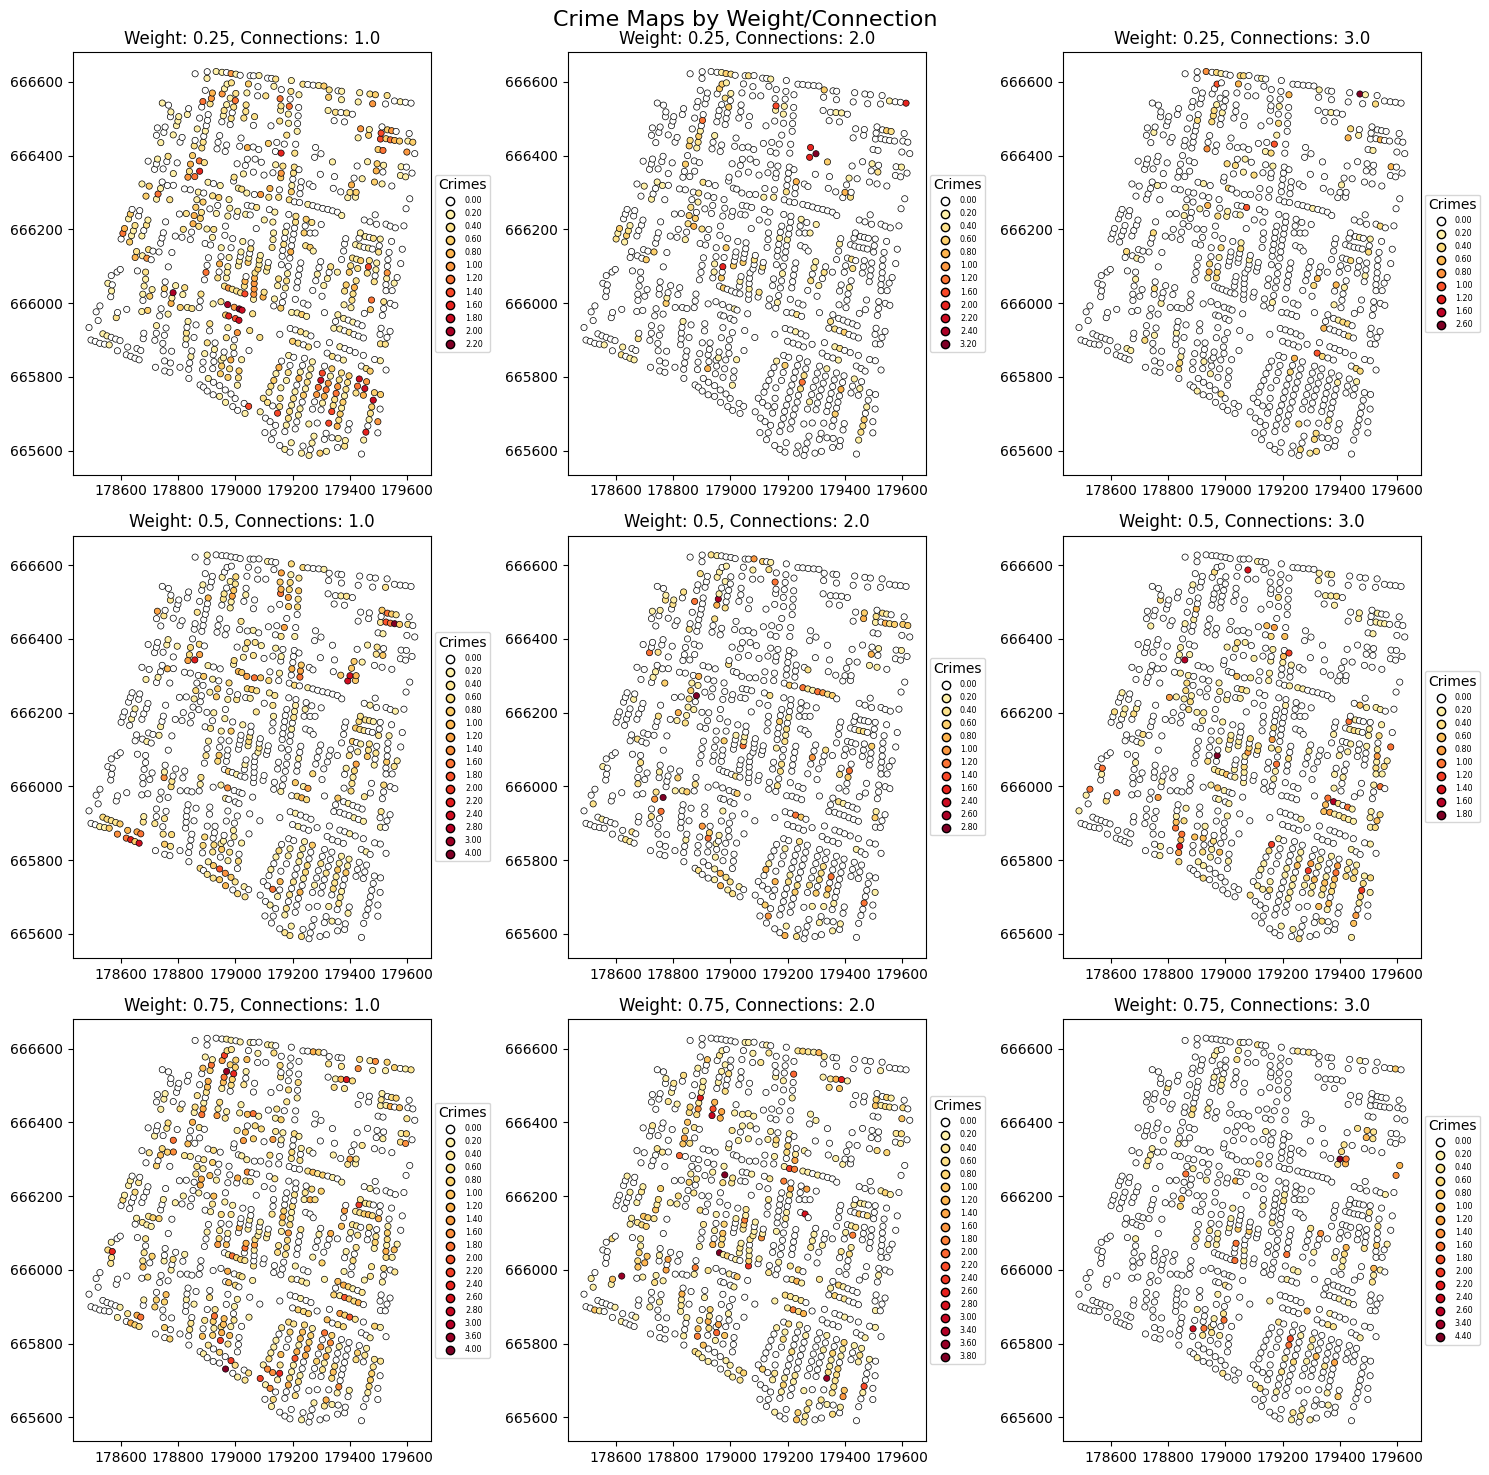

In [11]:
# Figure object with 9 axes
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Unique combinations of weight and connections
unique_combinations = df_map.groupby(['weight', 'connections']).size().reset_index()[['weight', 'connections']]

# Custom color map function
def custom_cmap(crimes):
    unique_crimes = sorted(crimes.unique())
    n_colors = len(unique_crimes) - 1  # Exclude 0
    colors = plt.cm.YlOrRd(np.linspace(0.1, 1, n_colors))  # Yellow-Orange-Red color map
    colors = np.vstack(([1, 1, 1, 1], colors))  # Add white for zero crimes
    return ListedColormap(colors), unique_crimes

for i, (weight, connections) in enumerate(unique_combinations.values):
    # Select rows with the current combination of weight and connections
    filtered_df = df_map[(df_map['weight'] == weight) & (df_map['connections'] == connections)]
    
    # Compute the average number of crimes for each unique combination of X and Y
    avg_crimes = filtered_df.groupby(['geometryx', 'geometryy'])['crimes'].mean().reset_index()
    
    # Create custom colormap and get unique crime values
    cmap, unique_crimes = custom_cmap(avg_crimes['crimes'])
    
    # Create a scatterplot using matplotlib
    scatter = axes[i].scatter(avg_crimes['geometryx'], avg_crimes['geometryy'], 
                              c=avg_crimes['crimes'], cmap=cmap, s=20, 
                              edgecolors='black', linewidth=0.5)
    
    # Add a legend
    legend_elements = [plt.scatter([], [], c=[cmap(i/(len(unique_crimes)-1))], 
                                   label=f'{c:.2f}', edgecolors='black') 
                       for i, c in enumerate(unique_crimes)]
    axes[i].legend(handles=legend_elements, title='Crimes', loc='center left', 
                   bbox_to_anchor=(1, 0.5), fontsize='xx-small')
    
    # Add a title to the map
    axes[i].set_title(f'Weight: {weight}, Connections: {connections}')
    
    # Remove axis labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Add a main title to the figure
fig.suptitle('Crime Maps by Weight/Connection', fontsize=16)

# Adjust layout and save
plt.tight_layout()
plt.savefig('crime_maps.png', dpi=300, bbox_inches='tight')
plt.show()